**<font color = black size=6>实验八：支持向量机</font>**

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cvxopt
from cvxopt import matrix
from cvxopt import solvers

**<font color = blue size=4>第一部分:函数介绍</font>**

二次规划问题是形式如下的一类最优化问题：
$$
\begin{align}
\min_x \quad  &\frac{1}{2}x^TPx+q^Tx \\
s.t. \quad  &Gx\leq h \\
      &Ax=b
\end{align}
$$
对于这一类问题可以使用[cvxopt](https://cvxopt.org/userguide/coneprog.html#quadratic-programming)库的solvers.qp()函数进行求解。

以下是一个例子（参考[Solving a quadratic program](https://cvxopt.org/examples/tutorial/qp.html)）:
$$
\begin{align}
\min_x \quad  &2x_1^2+x_2^2+x_1x_2+x_1+x_2 \\
s.t. \quad  &x_1\geq 0 \\
      &x_2\geq 0 \\
      &x_1+x_2=1
\end{align}
$$
为了使用solvers.qp()函数，我们需要知道在该二次规划问题中的$P,q,G,h,A,b$矩阵分别是什么。
在该优化问题中，

* $P:=\begin{bmatrix}
    4 & 1 \\ 1 & 2
   \end{bmatrix}$,
* $q:=\begin{bmatrix}
    1 \\ 1
   \end{bmatrix}$,
* $G:=\begin{bmatrix}
    -1 & 0 \\ 0 & -1
   \end{bmatrix}$,
* $h:=\begin{bmatrix}
    0 \\ 0
   \end{bmatrix}$,
* $A:=\begin{bmatrix}
    1 & 1
   \end{bmatrix}$,
* $b:=\begin{bmatrix}
    1
   \end{bmatrix}$,
   
把这些参数送入solvers.qp()函数中即可求出解。

In [6]:
# Tips1: cvxopt库中的matrix只接受double类型的数据
# Tips2: matrix使用列表作为参数创建矩阵和numpy.array使用列表作为参数创建矩阵是不同的
# print(matrix([[1.0, 1.0]]))#里面是列向量
# print(np.array([[1.0, 1.0]]))
# print(matrix(np.array([[1.0, 1.0]])))
Q = 2*matrix([ [2, .5], [.5, 1] ])
p = matrix([1.0,1.0])
G = matrix([[-1.0,0.0],[0.0,-1.0]])
h = matrix([0.0,0.0])
A = matrix([1.0, 1.0], (1,2))
b = matrix(1.0)
sol=solvers.qp(Q, p, G, h, A, b)
print(sol['x'])
sol

     pcost       dcost       gap    pres   dres
 0:  1.8889e+00  7.7778e-01  1e+00  2e-16  2e+00
 1:  1.8769e+00  1.8320e+00  4e-02  2e-16  6e-02
 2:  1.8750e+00  1.8739e+00  1e-03  2e-16  5e-04
 3:  1.8750e+00  1.8750e+00  1e-05  1e-16  5e-06
 4:  1.8750e+00  1.8750e+00  1e-07  1e-16  5e-08
Optimal solution found.
[ 2.50e-01]
[ 7.50e-01]



{'x': <2x1 matrix, tc='d'>,
 'y': <1x1 matrix, tc='d'>,
 's': <2x1 matrix, tc='d'>,
 'z': <2x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 1.052702838051502e-07,
 'relative gap': 5.614415451491214e-08,
 'primal objective': 1.875000000000018,
 'dual objective': 1.8749998947297342,
 'primal infeasibility': 1.1102230246251565e-16,
 'dual infeasibility': 5.3147592893303475e-08,
 'primal slack': 0.2500000952702475,
 'dual slack': 1.0000000000000038e-08,
 'iterations': 4}

**<font color = blue size=4>第二部分:实验任务</font>**

1.线性可分支持向量机与硬间隔最大化

<span style="color:purple">1) 读入数据集'dataset1.csv',把数据类型都转换成np.double类型，并画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色。</span>

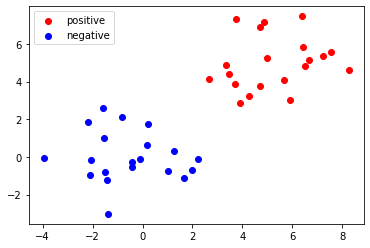

In [2]:
# ---- Your code here ----
d1frame=pd.read_csv('dataset1.csv')
d1=np.double(d1frame)

label=d1[:,2]
plt.scatter(d1[label==1,0],d1[label==1,1],c='red',label='positive')
plt.scatter(d1[label==-1,0],d1[label==-1,1],c='blue',label='negative')
plt.legend()
plt.show()



<span style="color:purple">2) 求解如下对偶问题（参考课件）：</span>
$$
\begin{align}
\min_\lambda \quad  &\frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\lambda_i\lambda_jy_iy_j\pmb{x}_i^T\pmb{x}_j-\sum_{i=1}^m\lambda_i \\
s.t. \quad  &\sum_{i=1}^m\lambda_iy_i=0 \\
      &\pmb{\lambda}\geq \pmb{0}
\end{align}
$$

这个优化问题是一个二次规划问题。
* $P是一个m\times m的矩阵，其中P_{ij}=y_iy_j\pmb{x}_i^T\pmb{x}_j$,
* $q是一个m\times 1的所有值都为-1的列向量，即q:=\begin{bmatrix}
    -1 & -1 & \cdots & -1
   \end{bmatrix}^T$,
* $G:=\begin{bmatrix}
    -1 & 0 & \cdots & 0 \\
    0 & -1 & \cdots & 0 \\
   \vdots & \vdots & \ddots &0 \\
   0 & 0 & 0 & -1
   \end{bmatrix}_{m\times m}=-\pmb{I},\pmb{I}为单位矩阵,$
* $h是一个m\times 1的零向量,即h:=\begin{bmatrix}
    0 & 0 & \cdots & 0
   \end{bmatrix}^T$,
* $A:=\begin{bmatrix}
    y_1 & y_2 & \cdots & y_m
   \end{bmatrix}^T$,
* $b:=\begin{bmatrix}
    0
   \end{bmatrix},一个标量$
   
<span style="color:purple">把上述参数送入求解器solvers.qp()中即可得到最优解$\lambda^*$</span>。 
 
附：$P$矩阵的一个计算方法：
设$X=\begin{bmatrix}
    x_{11} & x_{12} \\
    x_{21} & x_{22} \\
    \vdots & \vdots \\
    x_{m1} & x_{m2}
   \end{bmatrix}$,
   $Y=\begin{bmatrix}
    y_{1} \\
    y_{2} \\
    \vdots \\
    y_{m}
   \end{bmatrix}$,
   
计算$X'=\begin{bmatrix}
    x_{11}y_1 & x_{12}y_1 \\
    x_{21}y_2 & x_{22}y_2 \\
    \vdots & \vdots \\
    x_{m1}y_m & x_{m2}y_m
   \end{bmatrix}=X*Y(注意这里是星乘)$
   
则$P=X'X'^T$。

In [3]:
# ---- Your code here ----
#如果求解报错可以尝试在solvers.qp()中添加参数kktsolver='ldl'
m=len(d1)
X=np.array(d1[:,0:2])
Y=np.array(d1[:,2:3])
Xt=X*Y
P=Xt.dot(Xt.T)
q=-np.ones(m)
G=-np.identity(m)
h=np.zeros(m)
b=matrix(0.)
sol=solvers.qp(matrix(P),matrix(q),matrix(G),matrix(h),matrix(Y.reshape(1,m)),b)


     pcost       dcost       gap    pres   dres
 0: -5.2553e+00 -9.0147e+00  1e+02  1e+01  2e+00
 1: -4.9265e+00 -1.9551e+00  2e+01  2e+00  3e-01
 2: -1.5759e-01 -3.1831e-01  7e-01  4e-02  7e-03
 3: -1.3147e-01 -1.9706e-01  7e-02  4e-17  9e-16
 4: -1.7378e-01 -1.8099e-01  7e-03  5e-17  1e-15
 5: -1.7979e-01 -1.8010e-01  3e-04  3e-17  9e-16
 6: -1.8003e-01 -1.8003e-01  3e-06  2e-17  7e-16
 7: -1.8003e-01 -1.8003e-01  3e-08  4e-17  8e-16
Optimal solution found.


<span style="color:purple">3) 求出$\pmb{\omega}^*=\sum_{i=1}^m\lambda_i^*y_i\pmb{x}_i$和$b^*=y_j-\pmb{\omega}^{*T}\pmb{x_j}$, 其中$j$为$\lambda^*$中的一个正分量$\lambda_j^*>0$的下标。注意：由于求解器求出来的是一个近似解，所以$\lambda^*$中很多实际上为0的分量会略大于0，这时候可以设置一个阈值把非常靠近0的那些分量筛去，再从剩下的分量中选取一个正分量来计算$b^*$,或者也可以直接取$\lambda^*$中最大的分量来计算$b^*$。</span>

In [4]:
# ---- Your code here ----
w=np.zeros(2)
bs=0
lamb=np.array(sol['x'])
for i in range(m):
    w+=lamb[i]*Y[i]*X[i,:]
for i in range(m):
    if lamb[i]==max(lamb):
        print('yes')
        bs+=Y[i]-w.T.dot(X[i,:])


yes


<span style="color:purple">4) 画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色，再为支持向量（训练数据中$\lambda_j^*>0$的对应的样本）标上不同的颜色，并画出决策边界$\pmb{\omega}^{*T}\pmb{x}+b=0$和间隔边界$\pmb{\omega}^{*T}\pmb{x}+b=1$与$\pmb{\omega}^{*T}\pmb{x}+b=-1$。</span>

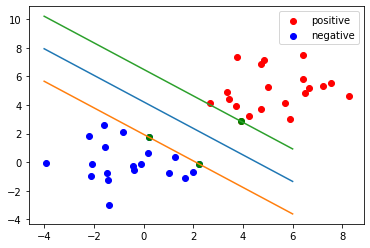

In [11]:
# ---- Your code here ----
label=d1[:,2]
x1=t=np.arange(-4,8,2)
plt.scatter(d1[label==1,0],d1[label==1,1],c='red',label='positive')
plt.scatter(d1[label==-1,0],d1[label==-1,1],c='blue',label='negative')
for i in range(m):
    if lamb[i]>0.001:
        plt.scatter(d1[i,0],d1[i,1],c='green')
x2=-w[0]/w[1]*x1-bs/w[1]
plt.plot(x1,x2)
x2=-w[0]/w[1]*x1-(bs+1)/w[1]
plt.plot(x1,x2)
x2=-w[0]/w[1]*x1-(bs-1)/w[1]
plt.plot(x1,x2)
plt.legend()
plt.show()



2.线性支持向量机与软间隔最大化

<span style="color:purple">1) 读入数据集'dataset2.csv',把数据类型都转换成np.double类型，并画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色。</span>

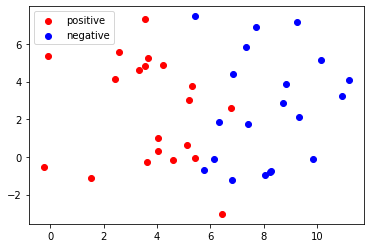

In [12]:
# ---- Your code here ----

d2frame=pd.read_csv('dataset2.csv')
d2=np.double(d2frame)

label2=d2[:,2]
plt.scatter(d2[label2==1,0],d1[label2==1,1],c='red',label='positive')
plt.scatter(d2[label2==-1,0],d1[label2==-1,1],c='blue',label='negative')
plt.legend()
plt.show()

<span style="color:purple">2) 选择一个参数C，求解如下对偶问题（参考课件）：</span>
$$
\begin{align}
\min_\lambda \quad  &\frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\lambda_i\lambda_jy_iy_j\pmb{x}_i^T\pmb{x}_j-\sum_{i=1}^m\lambda_i \\
s.t. \quad  &\sum_{i=1}^m\lambda_iy_i=0 \\
      &\pmb{0}\leq \pmb{\lambda}\leq C 
\end{align}
$$
* $G:=\begin{bmatrix}
    -1 & 0 & \cdots & 0 \\
    0 & -1 & \cdots & 0 \\
   \vdots & \vdots & \ddots &0 \\
   0 & 0 & 0 & -1 \\
   1 & 0 & \cdots & 0 \\
    0 & 1 & \cdots & 0 \\
   \vdots & \vdots & \ddots &0 \\
   0 & 0 & 0 & 1
   \end{bmatrix}_{2m\times m}=\begin{bmatrix}
    -\pmb{I} \\
    \pmb{I}
   \end{bmatrix},\pmb{I}为单位矩阵,$
* $h:=\begin{bmatrix}
    0 \\
    0 \\
    \vdots \\
    0 \\
    C \\
    C \\
    \vdots \\
    C
   \end{bmatrix}_{2m\times 1}, 即一个m\times 1的零列向量与一个m\times 1的分量全为C的列向量上下拼接$,
* $P,q,A,b$与硬间隔优化问题中的矩阵相同。

In [75]:
# ---- Your code here ----
m=len(d2)
X=np.array(d2[:,0:2])
Y=np.array(d2[:,2:3])
Xt=X*Y
P=Xt.dot(Xt.T)
q=-np.ones(m)
G=np.r_[-np.identity(m),np.identity(m)]
h=np.r_[np.zeros(m),10*np.ones(m)]#####
b=matrix(0.)
sol=solvers.qp(matrix(P),matrix(q),matrix(G),matrix(h),matrix(Y.reshape(1,m)),b)



     pcost       dcost       gap    pres   dres
 0: -6.2063e+01 -2.7111e+03  7e+03  7e-01  1e-13
 1: -3.8357e+01 -7.9488e+02  1e+03  9e-02  1e-13
 2: -2.9957e+01 -1.5622e+02  2e+02  1e-02  2e-13
 3: -4.3077e+01 -7.8410e+01  4e+01  2e-03  2e-13
 4: -5.0581e+01 -5.8786e+01  8e+00  2e-04  2e-13
 5: -5.1936e+01 -5.4984e+01  3e+00  8e-05  2e-13
 6: -5.2960e+01 -5.4378e+01  1e+00  1e-05  2e-13
 7: -5.3514e+01 -5.3543e+01  3e-02  2e-07  2e-13
 8: -5.3522e+01 -5.3522e+01  3e-04  2e-09  2e-13
 9: -5.3522e+01 -5.3522e+01  3e-06  2e-11  2e-13
Optimal solution found.


<span style="color:purple">3) 求出$\pmb{\omega}^*=\sum_{i=1}^m\lambda_i^*y_i\pmb{x}_i$和$b^*=y_j-\pmb{\omega}^{*T}\pmb{x_j}$, 其中$j$为$\lambda^*$中的一个正分量$0<\lambda_j^*<C$的下标。与硬间隔优化问题同理，应该筛掉非常接近0和非常接近$C$的分量。</span>

In [56]:
# print(sol['x'])

In [80]:
# ---- Your code here ----
w=np.zeros(2)
bs=0
lamb=np.array(sol['x'])
for i in range(m):
    w+=lamb[i]*Y[i]*X[i,:]

for i in range(m):
    if lamb[i]>0.001 and lamb[i]<9:

        if Y[i]-w.T.dot(X[i,:])>bs:
            bs=Y[i]-w.T.dot(X[i,:])



<span style="color:purple">4) 画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色，再为支持向量（训练数据中$\lambda_j^*>0$的对应的样本）标上不同的颜色，并画出决策边界$\pmb{\omega}^{*T}\pmb{x}+b=0$和间隔边界$\pmb{\omega}^{*T}\pmb{x}+b=1$与$\pmb{\omega}^{*T}\pmb{x}+b=-1$。</span>

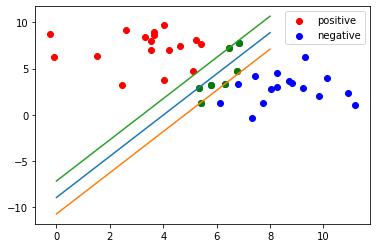

In [81]:
# ---- Your code here ----
x1=t=np.arange(0,10,2)
plt.scatter(d2[label2==1,0],d2[label2==1,1],c='red',label='positive')
plt.scatter(d2[label2==-1,0],d2[label2==-1,1],c='blue',label='negative')
for i in range(m):
    if lamb[i]>0.001:
        plt.scatter(d2[i,0],d2[i,1],c='green')
x2=-w[0]/w[1]*x1-bs/w[1]
plt.plot(x1,x2)
x2=-w[0]/w[1]*x1-(bs+1)/w[1]
plt.plot(x1,x2)
x2=-w[0]/w[1]*x1-(bs-1)/w[1]
plt.plot(x1,x2)
plt.legend()
plt.show()


3.非线性支持向量机与核函数

[Raisin Dataset](https://www.kaggle.com/datasets/muratkokludataset/raisin-dataset)是一个葡萄干的数据集，总共有900个样本，每个样本包含7个(都是连续的)特征以及1个标签，每个标签只有两种可能取值。本次实验已经按照8：2的比例划分成了训练数据集'Raisin_train.csv'以及测试数据集'Raisin_test.csv'，且每个数据集都已经做了特征归一化处理以及把标签的值替换成了+1和-1。

<span style="color:purple">1) 读入训练数据集'Raisin_train.csv',把数据类型都转换成np.double类型。</span>

In [12]:
# ---- Your code here ----
rtrainf=pd.read_csv('Raisin_train.csv')
rtrain=np.double(rtrainf)


<span style="color:purple">2) 选择一个核函数$K(\pmb{x},\pmb{z})$以及参数C，求解如下对偶问题（参考课件）：</span>
$$
\begin{align}
\min_\lambda\quad   &\frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\lambda_i\lambda_jy_iy_jK(\pmb{x}_i,\pmb{x}_j)-\sum_{i=1}^m\lambda_i \\
s.t. \quad  &\sum_{i=1}^m\lambda_iy_i=0 \\
      &\pmb{0}\leq \pmb{\lambda}\leq C 
\end{align}
$$

相较于软间隔最大化的优化问题，该优化问题仅需要对矩阵$P$做改动。
从以下常用的核函数中选择一个作为该优化问题中的$K$（参数自己进行调整）：
* 线性核：$K(\pmb{x},\pmb{z})=\pmb{x}^T\pmb{z}$
* 多项式核：$K(\pmb{x},\pmb{z})=(\pmb{x}^T\pmb{z}+1)^p$
* 高斯核：$K(\pmb{x},\pmb{z})=exp(-\frac{\parallel \pmb{x}-\pmb{z} \parallel^2}{2\sigma^2})$
* 拉普拉斯核：$K(\pmb{x},\pmb{z})=exp(-\frac{\parallel \pmb{x}-\pmb{z} \parallel}{\sigma})$
* Sigmoid核：$K(\pmb{x},\pmb{z})=tanh(\beta\pmb{x}^T\pmb{z}+\theta)$

则$P是一个m\times m的矩阵，其中P_{ij}=y_iy_jK(\pmb{x_i},\pmb{x_j})$。

In [20]:
# ---- Your code here ----



m=len(rtrain)
X=np.array(rtrain[:,0:7])
Y=np.array(rtrain[:,7:8])

Xt=X*Y
P=Xt.dot(Xt.T)


q=-np.ones(m)
G=np.r_[-np.identity(m),np.identity(m)]
h=np.r_[np.zeros(m),0.1*np.ones(m)]#####
b=matrix(0.)
sol=solvers.qp(matrix(P),matrix(q),matrix(G),matrix(h),matrix(Y.reshape(1,m)),b)

# m=len(rtrain)
# X=np.array(rtrain[:,0:7])
# Y=np.array(rtrain[:,7:8])


# P=1 / (1 + np.exp(-X.dot(X.T)/7))
# P*=Y
# P*=Y.reshape(1,m)

# q=-np.ones(m)
# G=np.r_[-np.identity(m),np.identity(m)]
# h=np.r_[np.zeros(m),100*np.ones(m)]#####
# b=matrix(0.)
# sol=solvers.qp(matrix(P),matrix(q),matrix(G),matrix(h),matrix(Y.reshape(1,m)),b)



     pcost       dcost       gap    pres   dres
 0: -2.1515e+02 -2.1332e+02  1e+04  4e+01  9e-15
 1: -3.6656e+01 -2.0474e+02  6e+02  2e+00  8e-15
 2: -2.6211e+01 -1.1790e+02  9e+01  9e-16  1e-15
 3: -3.2063e+01 -4.3620e+01  1e+01  2e-16  1e-15
 4: -3.7133e+01 -3.9316e+01  2e+00  4e-16  1e-15
 5: -3.7971e+01 -3.8591e+01  6e-01  2e-16  1e-15
 6: -3.8192e+01 -3.8386e+01  2e-01  2e-16  1e-15
 7: -3.8269e+01 -3.8312e+01  4e-02  5e-16  1e-15
 8: -3.8284e+01 -3.8298e+01  1e-02  2e-16  1e-15
 9: -3.8290e+01 -3.8291e+01  1e-03  4e-16  1e-15
10: -3.8291e+01 -3.8291e+01  1e-05  8e-16  1e-15
Optimal solution found.


<span style="color:purple">3) 求出$b^*=y_j-\sum_{i=1}^m \lambda_i^*y_iK(\pmb{x_i},\pmb{x_j})$, 其中$j$为$\lambda^*$中的一个正分量$0<\lambda_j^*<C$的下标。</span>

In [21]:
# ---- Your code here ----
 
w=np.zeros(7)
bs=0
lamb=np.array(sol['x'])
for i in range(m):
    w+=lamb[i]*Y[i]*X[i,:]

for i in range(m):
    if lamb[i]>0.001 and lamb[i]<0.09:
        if Y[i]-w.T.dot(X[i,:])>bs:
            bs=Y[i]-w.T.dot(X[i,:])



# bs=-1000
# lamb=np.array(sol['x'])

# for i in range(m):
#     if lamb[i]>0.001 and lamb[i]<90:
#         tem=0
#         for j in range(m):
#             tem+=lamb[j]*Y[j]/ (1 + np.exp(-X[i,:].T.dot(X[j,:])/7))
#         if Y[i]-tem>bs:
#             bs=Y[i]-tem

<span style="color:purple">4) 读入测试数据集'Raisin_test.csv',用分类决策函数$f(\pmb{x})=sign(\sum_{i=1}^m \lambda_i^*y_iK(\pmb{x}_i,\pmb{x})+b^*)$（注意这里的$m,\lambda_i^*,y_i,\pmb{x}_i$是训练集的, $\pmb{x}$是测试集的）进行预测，输出预测准确率。</span>

In [22]:
# ---- Your code here ----
rtestf=pd.read_csv('Raisin_test.csv')
rtest=np.double(rtestf)
Xtest=np.array(rtest[:,0:7])
Ytest=np.array(rtest[:,7:8])
total=0
for i in range(len(rtest)):
    tem=0
    tem+=w.T.dot(Xtest[i,:])
    tem+=bs
    if tem>=0 and Ytest[i]==1:
        total+=1
    if tem<0 and Ytest[i]==-1:
        total+=1
total/len(rtest)

# rtestf=pd.read_csv('Raisin_test.csv')
# rtest=np.double(rtestf)
# Xtest=np.array(rtest[:,0:7])
# Ytest=np.array(rtest[:,7:8])
# total=0
# for i in range(len(rtest)):
#     tem=0
#     for j in range(m):
#         tem+=lamb[j]*Y[j]/ (1 + np.exp(-Xtest[i,:].T.dot(X[j,:])/7))
#     tem+=bs
#     if tem>=0 and Ytest[i]==1:
#         total+=1
#     if tem<0 and Ytest[i]==-1:
#         total+=1
# total/len(rtest)


0.8777777777777778

**<font color = blue size=4>第三部分:作业提交</font>**

一、实验课下课前提交完成代码，如果下课前未完成，请将已经完成的部分进行提交，未完成的部分于之后的实验报告中进行补充  
要求:  
1)文件格式为：学号-姓名.ipynb  
2)【不要】提交文件夹、压缩包、数据集等无关文件，只需提交单个ipynb文件即可，如果交错请到讲台前联系助教，删掉之前的错误版本后再进行提交

二、实验报告下周五实验课(5月13号前)上课前提交报告  
要求：  
1)文件格式为：学号-姓名.pdf  
2)【不要】提交文件夹、压缩包、代码文件、数据集等任何与实验报告无关的文件，只需要提交单个pdf文件即可  
3)文件命名时不需要额外添加“实验几”等额外信息，按照格式提交  
4)每周的实验报告提交地址会变化，且有时间限制，提交时间为下周的实验课开始时，请注意及时提交。

实验八(支持向量机)的实验报告上交地址:https://workspace.jianguoyun.com/inbox/collect/3d50770a7555409fb8819559cdea19fd/submit

三、课堂课件获取地址:https://www.jianguoyun.com/p/DQlpUFYQp5WhChiS_q0E  
实验内容获取地址:https://www.jianguoyun.com/p/DbKbP-AQp5WhChi1sa0E